In [2]:
!nvidia-smi

Sun Sep  6 16:15:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from torch.autograd import Variable
import torchvision

In [4]:
torch.cuda.set_device(0)

In [5]:
class PartialConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super(PartialConv2d, self).__init__(*args, **kwargs)

        self.multi_channel = False
        self.return_mask = True
        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])
            
        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in
                        
                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1)

                # for mixed precision training, change 1e-8 to 1e-6
                self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = super(PartialConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)

        if self.return_mask:
            return output, self.update_mask
        else:
            return output

In [6]:
class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.ngf = 64
        self.define_module()

    def define_module(self):
        ngf = self.ngf
        in_dim = 64
        self.fc = nn.Sequential(
            nn.Linear(in_dim, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True))

        self.upsample1 = upBlock(ngf, ngf // 2)
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        self.to_rgb = TO_RGB_LAYER(ngf // 4)

    def forward(self, z_code):
        out_code = self.fc(z_code)
        out_code = out_code.view(-1, self.ngf, 4, 4)  # 64 * 4 * 4
        out_code = self.upsample1(out_code)              # 32 * 8 * 8
        out_code = self.upsample2(out_code)              # 16 * 16 * 16
        img = self.to_rgb(out_code)
        return img
    

class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.define_module()

    def define_module(self):
        ndf = 16
        self.from_rgb = fromRGB_layer(ndf)
        self.downblock1 = downBlock_p(ndf, ndf * 2, 3, 1, 1)
        self.downblock2 = downBlock_p(ndf * 2, ndf * 4, 3, 1, 1)
#         self.downblock3 = downBlock_p(ndf * 2, ndf * 2, 3, 1, 1)
        self.uncond_logits = PartialConv2d(ndf * 4, 1, kernel_size=4, stride=4)
    def forward(self, x_var, mask=None):
        """
        - x_var (tensor): 3x16x16
        - mask (tensor): 1x16x16
        """
        x_code = self.from_rgb(x_var)                 # 16 * 16 * 16
        x_code, mask = self.downblock1(x_code, mask)  # 32 * 8 * 8
        x_code, mask = self.downblock2(x_code, mask)  # 64 * 4 * 4

        rf_score, _ = self.uncond_logits(x_code, mask)
        rf_score = F.sigmoid(rf_score)
        return rf_score.view(-1)

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d):
        nn.init.orthogonal(m.weight.data, 1.0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.Linear):
        nn.init.orthogonal(m.weight.data, 1.0)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
    elif classname == 'PartialConv':
        nn.init.constant_(m.mask_conv.weight.data, 1.0)

        
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_planes),
        nn.LeakyReLU(0.2, inplace=True))
    return block


class TO_RGB_LAYER(nn.Module):
    def __init__(self, ngf):
        super().__init__()
        self.gf_dim = ngf
        self.img = nn.Sequential(
            nn.Conv2d(ngf, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, h_code):
        out_img = self.img(h_code)
        return out_img

    
class PartialConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, 
                 dilation=1, groups=1,bias=False):
        super().__init__()
        self.input_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv2d(
            1, 1, kernel_size, stride, padding, dilation, groups, False)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

        self.bias = self.input_conv.bias
        self.all = kernel_size * kernel_size
    def forward(self, input, mask):
        """
        input is regular tensor with shape N*C*H*W
        mask has to have 1 channel N*1*H*W

        mask: 0's for foreground
        """
        if mask is None:
            return self.input_conv(input), mask
        
        output = self.input_conv(input * mask)
        # get bias which will be used later
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            _frac = self.mask_conv(torch.ones_like(mask))
            mask = self.mask_conv(mask)

        no_update_holes = mask == 0
        mask_ratio = _frac / mask.masked_fill_(no_update_holes, 1.0)
        output_pre = (output - output_bias) * mask_ratio + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)
        new_mask = 1 - no_update_holes.float()
        return output, mask


class downBlock_p(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, 
                 dilation=1, groups=1, bias=False):
        super().__init__()
        self.conv = PartialConv2d(in_channels, out_channels,
            kernel_size, stride, padding, dilation, groups, bias)
        # self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, input, mask=None):
        """
        input is regular tensor with shape N*C*H*W
        mask has to have 1 channel N*1*H*W
        """
        output, mask = self.conv(input, mask)
        # output = self.bn(output)
        output = F.leaky_relu(output, 0.2, inplace=True)
        output = F.avg_pool2d(output, 2)
        if mask is not None:
            mask = F.avg_pool2d(mask, 2)
            no_update_holes = mask == 0
            mask = 1 - no_update_holes.float()
        return output, mask
    
    
def fromRGB_layer(out_planes):
    layer = nn.Sequential(
        nn.Conv2d(3, out_planes, 1, 1, 0, bias=False),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return layer

In [10]:
norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def get_mask(imshape, bbox):
    """
    mask: 0's for foreground
    """
    c, r = imshape
    x1, y1, w, h = bbox
    x2 = x1 + w
    y2 = y1 + h
    mk = np.ones((r, c))
    mk[y1: y2 + 1, x1: x2 + 1] = 0
    return Image.fromarray(mk)

def train_img_gen(mask_size=-1):
    """
    - mask_size (int): -1: random mask
                       0 ~ imsize: fixed size
    """

    imsize = 16
    img = 255 * np.concatenate((np.ones((imsize,imsize,1)), np.zeros((imsize,imsize,2))), axis=2).astype(np.uint8)
    if mask_size == -1:
        bbox = np.random.randint(0, imsize, 4)
        x1 = np.min(bbox[0: 2])
        x2 = np.max(bbox[0: 2])
        y1 = np.min(bbox[2: 4])
        y2 = np.max(bbox[2: 4])
    elif mask_size == 0:
        x1, y1, x2, y2 = 0, 0, -1, -1
    elif mask_size == imsize:
        x1, y1 = 0, 0
        x2, y2 = imsize-1, imsize-1
    else:
        bbox = np.random.randint(0, imsize-mask_size+1, 2)
        x1 = bbox[0]
        x2 = x1 + mask_size - 1
        y1 = bbox[1]
        y2 = y1 + mask_size - 1
    img[y1: y2 + 1, x1: x2 + 1, 0] = 0
    img[y1: y2 + 1, x1: x2 + 1, 1] = 255
    # print(x1,y1,x2,y2)
    img = Image.fromarray(img)
    mk = torch.ones((1, imsize, imsize))
    mk[0, y1: y2 + 1, x1: x2 + 1] = 0
#     plt.hold()
#     plt.imshow(img)
#     plt.imshow(mk)
    return norm(img), mk

In [11]:
def imshow(im):
    _im = torchvision.utils.make_grid(im, pad_value=-1).detach().cpu().numpy()
    _im = np.transpose(_im, (1, 2, 0))
    _im = (_im + 1) * 255 / 2
    _im = _im.astype(np.uint8)
    plt.imshow(_im)

In [12]:
def prepare_data(batch_size, mask_size):
    imsize = 16
    im_li = []
    mk_li = []
    for i in range(batch_size):
        im, mk = train_img_gen(mask_size)
        im = im.view(1, 3, imsize, imsize)
        # imshow(im)
        mk = mk.view(1, 1, imsize, imsize)
        im_li.append(im)
        mk_li.append(mk)
    ims = torch.cat(im_li, dim=0).cuda() 
    mks = torch.cat(mk_li, dim=0).cuda()
    return ims, mks

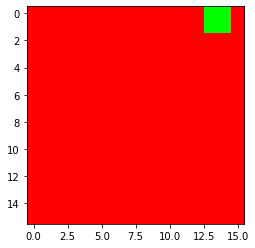

In [13]:
im, _ = prepare_data(1,2)
imshow(im[0])

In [18]:
max_count = 50001
batch_size = 16
mask_size = -1
nz = 64

In [19]:
netG = G().cuda()
netD = D().cuda()
netG.apply(weights_init)
netD.apply(weights_init)
optD = optim.Adam(netD.parameters(),
                  lr=2e-4,
                  betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(),
                  lr=2e-4,
                  betas=(0.5, 0.999))
criterion_one = nn.BCELoss().cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/50]Loss_D: 0.58 Loss_G: 1.90 Time: 15.68s
[2/50]Loss_D: 0.19 Loss_G: 2.17 Time: 15.55s
[3/50]Loss_D: 0.19 Loss_G: 2.69 Time: 15.02s
[4/50]Loss_D: 0.10 Loss_G: 4.20 Time: 15.12s
[5/50]Loss_D: 0.04 Loss_G: 5.46 Time: 14.96s
[6/50]Loss_D: 0.10 Loss_G: 4.06 Time: 15.11s
[7/50]Loss_D: 0.14 Loss_G: 3.07 Time: 15.11s
[8/50]Loss_D: 0.20 Loss_G: 2.20 Time: 15.00s
[9/50]Loss_D: 0.02 Loss_G: 6.87 Time: 15.10s
[10/50]Loss_D: 0.02 Loss_G: 6.21 Time: 15.09s
[11/50]Loss_D: 0.02 Loss_G: 5.64 Time: 14.95s
[12/50]Loss_D: 0.06 Loss_G: 3.96 Time: 15.01s
[13/50]Loss_D: 0.01 Loss_G: 11.38 Time: 15.21s
[14/50]Loss_D: 0.04 Loss_G: 4.11 Time: 15.18s
[15/50]Loss_D: 0.01 Loss_G: 9.25 Time: 15.24s
[16/50]Loss_D: 0.05 Loss_G: 6.34 Time: 14.96s
[17/50]Loss_D: 0.00 Loss_G: 14.83 Time: 14.99s
[18/50]Loss_D: 0.03 Loss_G: 4.58 Time: 15.23s
[19/50]Loss_D: 0.02 Loss_G: 4.69 Time: 15.05s
[20/50]Loss_D: 0.00 Loss_G: 14.37 Time: 15.14s
[21/50]Loss_D: 0.01 Loss_G: 5.70 Time: 14.83s
[22/50]Loss_D: 0.02 Loss_G: 4.65 Time: 1

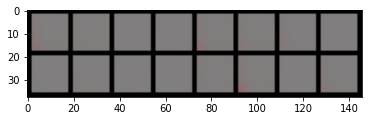

In [20]:
ep = 0
netG.train()

start_t = time.time()
for count in range(1, max_count):
    ims, mks = prepare_data(batch_size, mask_size)

    noise = Variable(torch.FloatTensor(batch_size, nz)).cuda()
    noise.data.normal_(0, 1)
    fake_ims = netG(noise)
    
    # train D    
    netD.zero_grad()
    real_logits = netD(ims, mks)
    fake_logits = netD(fake_ims.detach())
    fake_labels = torch.zeros_like(fake_logits)
    real_labels = torch.ones_like(real_logits)
    errD_real = criterion_one(real_logits, real_labels) # Real/Fake loss for the real image
    errD_fake = criterion_one(fake_logits, fake_labels) # Real/Fake loss for the fake image
    errD = errD_real + errD_fake
    errD.backward()
    optD.step()
    
    # train G
    netG.zero_grad()
    netD.zero_grad()
    fake_logits = netD(fake_ims)
    real_labels = torch.ones_like(fake_logits)
    errG = criterion_one(fake_logits, real_labels)
    errG.backward()
    optG.step()
    
    if count % 1000 == 0:
        ep += 1
        end_t = time.time()
        print('[%d/%d]Loss_D: %.2f Loss_G: %.2f Time: %.2fs'
              % (ep, int(max_count/1000),
                 errD.item(), errG.item(),
                 end_t - start_t))
        imshow(fake_ims)
        start_t = time.time()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.0029, 0.0019, 0.0031, 0.0030, 0.0031, 0.0031, 0.0032, 0.0032, 0.0031,
        0.0029, 0.0019, 0.0030, 0.0021, 0.0026, 0.0021, 0.0031],
       device='cuda:0', grad_fn=<ViewBackward>)

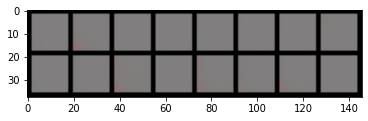

In [22]:
netG.eval()
_noise = Variable(torch.FloatTensor(batch_size, nz)).cuda()
_noise.data.normal_(0, 1)
imshow(netG(_noise))
netD(netG(_noise))

In [23]:
conv2d = PartialConv2d(3, 1, 3, 2, 0, bias=False)
conv = PartialConv(3, 1, 3, 2, 0, bias=False)
conv.input_conv.weight = conv2d.weight
nn.init.constant(conv.mask_conv.weight, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  after removing the cwd from sys.path.


Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [27]:
im, _ = prepare_data(1, 0)
netD(im)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.9999], device='cuda:0', grad_fn=<ViewBackward>)